In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

# 读取数据

In [2]:
x_data = pd.read_excel("Shenyan_S82_ESPdescriptor+汪老师提取的所有特征-不含FE.xlsx")
x_data

,c1nc[nH]n1,c1c[nH]cn1,c1cc[nH]c1,c1ccncc1,c1ccc2[nH]ccc2c1,c1ccc2scnc2c1,c1ccc2cc3ccccc3cc2c1,c1cscn1,c1ccsc1,c1cn[nH]c1,c1ccc2occcc2c1,c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2,c1ccccc1,c1nnn[nH]1,c1ccc2sc[n+]c2c1,c1ccc2ncccc2c1,c1nncs1,Alkene,Alkylchloride,Alkylfluoride,Alkylbromide,Trifluoromethyl,Alcohol,Althoxyl,Primary_aliph_amine,Secondary_aliph_amine,Tertiary_aliph_amine,Primary_arom_amine,Secondary_arom_amine,Tertiary_arom_amine,Alkylthiol,Dialkylthioether,Disulfide,Aldehyde,Ketone,Oxime,Acetal,Hemiacetal,Thioacetal,Chloroalkene,Bromoalkene,Enol,Carboxylic_acid,Carboxylic_ester,Lactone,Amide,Lactam,Nitrile,Thiourea,Phenol,Arylchloride,Arylfluoride,Arylbromide,Aryliodide,Arylthiol,Oxoarene,Azo,Nitro,Sulfon,Sulfonic_derivative,Phosphonic_acid_derivative,Tri_boron,Sugar_pattern_combi,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Num of Conju-Strut,Num of Conju-All-Atoms,Atom Num Conju-All Ratio,AtomWt Conju-All Ratio,Full-Mol Wiener Index,Individual Conju-Atom Number (Max-Conju),Conju-Part-Wt (Max-Conju),Conju-AtomicWt (Max-Conju),Max Conju-Distance (Max-Conju),Conju-Branch Index (Max-Conju),Conju-Strut Wiener Index (Max-Conju),Atom_PEOE-Charge_Sum,Atom_LogP_Sum,Atom_MR_Sum,Atom_PEOE-Charge_Mean,Atom_LogP_Mean,Atom_MR_Mean,Atom_PEOE-Charge_Std,Atom_LogP_Std,Atom_MR_Std,Atom_PEOE-Charge_Max,Atom_LogP_Max,Atom_MR_Max,Atom_PEOE-Charge_Min,Atom_LogP_Min,Atom_MR_Min,Atom_PEOE-Charge_Delta,Atom_LogP_Delta,Atom_MR_Delta,Fun_PEOE-Charge_Sum,Fun_LogP_Sum,Fun_MR_Sum,Fun_PEOE-Charge_Mean,Fun_LogP_Mean,Fun_MR_Mean,Fun_PEOE-Charge_Std,Fun_LogP_Std,Fun_MR_Std,Fun_PEOE-Charge_Max,Fun_LogP_Max,Fun_MR_Max,Fun_PEOE-Charge_Min,Fun_LogP_Min,Fun_MR_Min,Fun_PEOE-Charge_Delta,Fun_LogP_Delta,Fun_MR_Delta,Mid-Fun_PEOE-Charge_Sum,Mid-Fun_LogP_Sum,Mid-Fun_MR_Sum,Mid-Fun_PEOE-Charge_Mean,Mid-Fun_LogP_Mean,Mid-Fun_MR_Mean,Mid-Fun_PEOE-Charge_Std,Mid-Fun_LogP_Std,Mid-Fun_MR_Std,Mid-Fun_PEOE-Charge_Max,Mid-Fun_LogP_Max,Mid-Fun_MR_Max,Mid-Fun_PEOE-Charge_Min,Mid-Fun_LogP_Min,Mid-Fun_MR_Min,Mid-Fun_PEOE-Charge_Delta,Mid-Fun_LogP_Delta,Mid-Fun_MR_Delta,Conju_PEOE-Charge_Sum,Conju_LogP_Sum,Conju_MR_Sum,Conju_PEOE-Charge_Mean,Conju_LogP_Mean,Conju_MR_Mean,Conju_PEOE-Charge_Std,Conju_LogP_Std,Conju_MR_Std,Conju_PEOE-Charge_Max,Conju_LogP_Max,Conju_MR_Max,Conju_PEOE-Charge_Min,Conju_LogP_Min,Conju_MR_Min,Conju_PEOE-Charge_Delta,Conju_LogP_Delta,Conju_MR_Delta,Atom Number,Occupied Orbitals,Molecule Weight,HOMO,LUMO,HOMO-LUMO Gap,Farthest Distance,Molecular Radius,Molecular Size Short,Molecular Size Medium,Molecular Size Long,Long/Sum Size Ratio,Length/Diameter,MPP,SDP,Dipole Moment (a.u.),Quadrupole Moment,Octopole Moment,ODI LUMO+1,ODI LUMO,ODI HOMO,ODI HOMO-1,ODI Mean,ODI Std,Isosurface area,Sphericity,Volume (Angstrom^3),Density (g/cm^3),LEAE Minimal Value,LEAE Maximal Value,Surfac

In [3]:
y_data = pd.read_csv("Target.csv", usecols=[3])
y_data

,FEaverage C2H4
0,17.866953
1,31.747821
2,20.754045
3,32.914965
4,29.873193
...,...
77,30.747600
78,36.079852
79,35.802155
80,28.578289


In [4]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [5]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  # 通过训练集获得归一化函数模型，使用 x_train 数据来计算缩放器需要的最小值和最大值
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)#使用拟合好的缩放器对 x_train 数据进行缩放
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [6]:
num_cores = multiprocessing.cpu_count()

In [9]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) # 5折交叉验证
#mse它测量的是预测值与实际值之间差值的平方的平均值。均方误差越小，模型的预测性能越好
variate=list(range(x_train.shape[1]))   #变量索引列表
selected=[]   #变量索引
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  
#验证集目前的分数和最好分数初始值都为无穷大（因为mse越小越好）
    
# def my_custom_loss_func(y, y_predict):
#     error = 0
#     for i in range(0, y.shape[1]):
#         error += mean_squared_error(y[:, i], y_predict[:, i])
#     error = error / y.shape[1]
#     return error

# my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

#循环筛选变量
while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  #逐个遍历自变量
        current_variate = selected+[i]   #当前变量
        current_x_train = x_train[:, current_variate]   #当前x_train
        current_x_test = x_test[:, current_variate]   #当前x_test
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
    selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])
        
        #if current_score>best_new_score:
            #variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
            #selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
            #current_score = best_new_score  #最新的分数等于最好的分数
            #print("score is {},continuing!".format(current_score))  #输出最小的mse值
        #else:
            #print("for selection over!")
            #break

In [10]:
selected

[202,
 145,
 216,
 146,
 172,
 288,
 235,
 123,
 50,
 264,
 164,
 185,
 115,
 295,
 147,
 130,
 17,
 51,
 126,
 73,
 257,
 59,
 219,
 97,
 134,
 102,
 225,
 242,
 116,
 14,
 96,
 224,
 165,
 28,
 294,
 293,
 118,
 91,
 153,
 240,
 183,
 19,
 38,
 5,
 98,
 125,
 163,
 180,
 0,
 21,
 1,
 2,
 4,
 6,
 249,
 9,
 11,
 13,
 223,
 195,
 22,
 15,
 267,
 284,
 154,
 129,
 16,
 18,
 20,
 155,
 162,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 47,
 139,
 53,
 56,
 60,
 62,
 110,
 45,
 108,
 10,
 44,
 55,
 57,
 29,
 92,
 232,
 203,
 61,
 158,
 127,
 258,
 236,
 262,
 72,
 259,
 25,
 23,
 201,
 114,
 251,
 192,
 255,
 8,
 212,
 270,
 46,
 209,
 186,
 7,
 198,
 95,
 99,
 75,
 82,
 234,
 121,
 196,
 231,
 113,
 167,
 181,
 131,
 256,
 27,
 243,
 128,
 94,
 152,
 200,
 304,
 170,
 101,
 117,
 107,
 233,
 184,
 303,
 124,
 76,
 291,
 58,
 269,
 187,
 151,
 90,
 241,
 250,
 34,
 160,
 207,
 246,
 237,
 222,
 122,
 138,
 299,
 42,
 218,
 169,
 143,
 132,
 109,
 30,
 247,
 194,
 238,
 161,
 211,
 148,
 21

In [11]:
train_mse_list

[0.029139531753429537,
 0.023670919124899444,
 0.023880408890418463,
 0.019409357565272567,
 0.018046306010066248,
 0.013642828333477358,
 0.012903026889821987,
 0.013496935614086538,
 0.013003823385017451,
 0.011089191306615143,
 0.011367129504184548,
 0.011132015304788828,
 0.010867299095246334,
 0.01088305163215214,
 0.010818922875724637,
 0.010875466112424088,
 0.010916024757669012,
 0.011028989863581102,
 0.011193500081639456,
 0.011008847072374966,
 0.010397241996753423,
 0.010505839805797158,
 0.010322204095445816,
 0.010044099066814121,
 0.00955590204887605,
 0.009717970571251365,
 0.009529390832211788,
 0.009605486179818573,
 0.009096874225055836,
 0.009197013510019173,
 0.009248326844860173,
 0.009661437665042502,
 0.009702477101332475,
 0.009699631970699358,
 0.009672061968561938,
 0.009830681197629141,
 0.009741579585011212,
 0.00968183876333328,
 0.009759121751586736,
 0.009814761694705059,
 0.009859801673178969,
 0.009892047793424662,
 0.009917638398547332,
 0.00992475746

In [12]:
val_mse_list

[0.03023391003882288,
 0.02807286354092416,
 0.02879161083927722,
 0.02802900525095676,
 0.02779804750000555,
 0.02382965206924785,
 0.02286493784365487,
 0.023139907990059834,
 0.02259140465487768,
 0.021109251191841795,
 0.020399560690012093,
 0.020010882660060965,
 0.019842162419649263,
 0.019814010402426273,
 0.019878644609878437,
 0.019678471628179733,
 0.01961041654387828,
 0.019633466528906674,
 0.019678087290529146,
 0.019662088642602077,
 0.018328784641898944,
 0.01839941598487425,
 0.018542109326889992,
 0.018218721687841187,
 0.017895757453855105,
 0.017721066016678402,
 0.017646780480886994,
 0.017613519958884938,
 0.017626272278933777,
 0.017660069447784033,
 0.017710987365954178,
 0.017714928601059242,
 0.017521664625752956,
 0.017453797690077735,
 0.017351100099611633,
 0.017216099923890293,
 0.01714800488159336,
 0.017123964210258257,
 0.017092385444907984,
 0.0170998382363751,
 0.017128211741887965,
 0.017160998150709723,
 0.017203121410758592,
 0.017262856082500753,
 

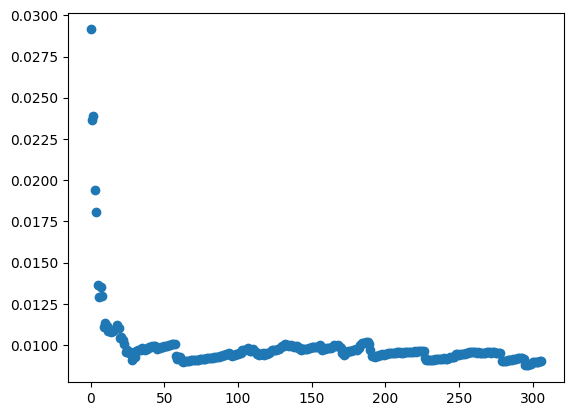

In [13]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

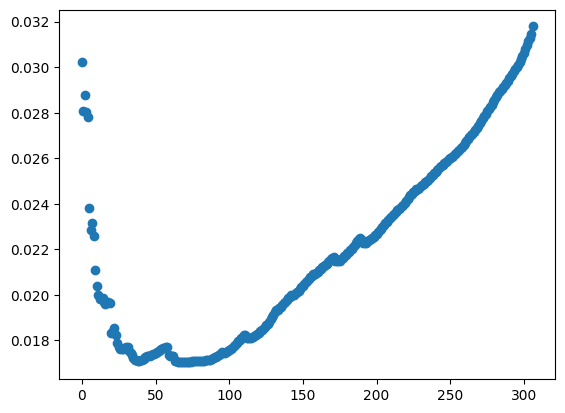

In [14]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [11]:
val_mse_list = [0.03023391003882288,
 0.02807286354092416,
 0.02879161083927722,
 0.02802900525095676,
 0.02779804750000555,
 0.02382965206924785,
 0.02286493784365487,
 0.023139907990059834,
 0.02259140465487768,
 0.021109251191841795,
 0.020399560690012093,
 0.020010882660060965,
 0.019842162419649263,
 0.019814010402426273,
 0.019878644609878437,
 0.019678471628179733,
 0.01961041654387828,
 0.019633466528906674,
 0.019678087290529146,
 0.019662088642602077,
 0.018328784641898944,
 0.01839941598487425,
 0.018542109326889992,
 0.018218721687841187,
 0.017895757453855105,
 0.017721066016678402,
 0.017646780480886994,
 0.017613519958884938,
 0.017626272278933777,
 0.017660069447784033,
 0.017710987365954178,
 0.017714928601059242,
 0.017521664625752956,
 0.017453797690077735,
 0.017351100099611633,
 0.017216099923890293,
 0.01714800488159336,
 0.017123964210258257,
 0.017092385444907984,
 0.0170998382363751,
 0.017128211741887965,
 0.017160998150709723,
 0.017203121410758592,
 0.017262856082500753,
 0.017306858441061404,
 0.01732384497467876,
 0.01733745971245564,
 0.017354965483126712,
 0.01738898359704021,
 0.017421371796509415,
 0.017447651953703274,
 0.017495445644947837,
 0.017522950463588677,
 0.01756824711585845,
 0.017605415810122454,
 0.017648365121869274,
 0.017676098165719085,
 0.01772371076265552,
 0.01773335201031989,
 0.01736194113887827,
 0.01730524614626606,
 0.017304472658338076,
 0.017312749958215905,
 0.01710094369347744,
 0.01708744526111012,
 0.017033896994585657,
 0.017047681821446233,
 0.017049535611142703,
 0.017051800419163772,
 0.017052063367026533,
 0.017059824749415906,
 0.017062527296940945,
 0.017066555438771537,
 0.01706980704283021,
 0.017068399055909282,
 0.01707911720571275,
 0.017081248929410875,
 0.017083656182581033,
 0.017088766425055697,
 0.017083958299006767,
 0.01709628446079906,
 0.017104414673541447,
 0.017117737767856963,
 0.017119104007883003,
 0.0171281306677283,
 0.01713643488434006,
 0.01714164491501586,
 0.017159142458575097,
 0.017184367921693162,
 0.017224516511167257,
 0.017267365012819925,
 0.0172927650773638,
 0.01733497322506783,
 0.017372412421854125,
 0.01742448109743617,
 0.01747821346907428,
 0.017442943794471522,
 0.017468383960581705,
 0.01750420643452054,
 0.017543450375473606,
 0.017595409302955594,
 0.017645253052134505,
 0.01768823231662036,
 0.01775075360062442,
 0.017812760724605834,
 0.017879368450613727,
 0.017956256827087454,
 0.018034524296786,
 0.01811429543955536,
 0.01817220452707565,
 0.018219630833990873,
 0.018239065553362768,
 0.01810201190435758,
 0.018096873747542354,
 0.01811462670492468,
 0.01812299339975921,
 0.018166939668770442,
 0.0182085202675607,
 0.018241175709040502,
 0.018293812820942012,
 0.01833115459847907,
 0.018396910001018018,
 0.01846696063059863,
 0.018510183360031483,
 0.018588034378846704,
 0.018661673688571204,
 0.018740623668724938,
 0.018828122955519312,
 0.018928906871018652,
 0.01903000724150985,
 0.01913014241077753,
 0.019229464816973105,
 0.01932028325641434,
 0.01933944104955715,
 0.019407860414992897,
 0.01948233218773348,
 0.019551888871748954,
 0.019632913166366936,
 0.019707032871382358,
 0.01977189242973438,
 0.01985104558187704,
 0.01991567425538078,
 0.019976002087754754,
 0.020005089217940496,
 0.02000984439940188,
 0.020083123287829765,
 0.020112211092442364,
 0.020181871683195615,
 0.02026416242622005,
 0.02034245275479115,
 0.020412891174672956,
 0.02047708374554493,
 0.020545926631039487,
 0.020611978224689242,
 0.020690690715249548,
 0.020773743889069073,
 0.02084937994264898,
 0.020928891056000813,
 0.020931718236701376,
 0.020977039011501872,
 0.021025571243675358,
 0.021089237240532018,
 0.02115585202375519,
 0.021241875282614973,
 0.02125889743216646,
 0.021321389297807292,
 0.021375757631703785,
 0.02144588046657315,
 0.02149942593976021,
 0.02155804014972946,
 0.02161220141263926,
 0.02164471067951163,
 0.0215063551261194,
 0.021500703464262094,
 0.02147360039485908,
 0.02149292193119067,
 0.02156959773220899,
 0.021634188167502448,
 0.02170176259500688,
 0.021770612358790086,
 0.021848053137853395,
 0.021903102367658567,
 0.02195355347683702,
 0.02202387948328871,
 0.02209714430872079,
 0.022175627362554406,
 0.022271874808220897,
 0.022358422021653723,
 0.02244613299770022,
 0.022500545768876435,
 0.022390220794296894,
 0.02228480089636812,
 0.022279040122051334,
 0.02230079001947354,
 0.022351543969694056,
 0.022406020152094374,
 0.022458178434562874,
 0.022510520228867535,
 0.022559051308733282,
 0.022622330218000888,
 0.022681708708853,
 0.02276103491313099,
 0.02283768556167659,
 0.02291399726093175,
 0.022984409189852166,
 0.02306335449856161,
 0.02314177548273417,
 0.023219333211707487,
 0.023295902308110197,
 0.02338254788487352,
 0.02344221698640671,
 0.023510446017919316,
 0.023573607493370223,
 0.023632341999610996,
 0.023707178071884483,
 0.023766384564192833,
 0.023831672737373386,
 0.023903758094556814,
 0.02396808320898985,
 0.024045741438886648,
 0.024136006911025,
 0.024224872804105072,
 0.02428957083602957,
 0.02436584064842843,
 0.02444112980309861,
 0.02451472575993608,
 0.024573545038487948,
 0.024645985400493113,
 0.02465803837695787,
 0.0246975193267928,
 0.02476140261840488,
 0.024822684164888798,
 0.02488212286115008,
 0.02493672893017534,
 0.024999828459365464,
 0.02506713155191233,
 0.025139380742699675,
 0.025210510959320986,
 0.02528260534280436,
 0.025348540042172147,
 0.025412452678179785,
 0.02547057817009471,
 0.025537799532413658,
 0.025598320198703405,
 0.025657762635944735,
 0.025717021382426465,
 0.025775953191873084,
 0.02583953567233238,
 0.025891146201139893,
 0.025951253834886213,
 0.025994048383682578,
 0.026053128786755753,
 0.026111853861822576,
 0.026181057307152304,
 0.026243639126695435,
 0.02630758384821954,
 0.026374236747904168,
 0.02644227124918838,
 0.02650584178445036,
 0.02658566478131243,
 0.026675849174133064,
 0.026748391705088782,
 0.026843227397636525,
 0.026932544477711224,
 0.027022451505209905,
 0.0270862963588423,
 0.02716267025866088,
 0.027256585679412283,
 0.027326359090752712,
 0.027434197168439284,
 0.027548153304671558,
 0.027643703873171842,
 0.027749520621830382,
 0.027852336380270088,
 0.027956992047595913,
 0.028061445516042664,
 0.028159409161224808,
 0.02822934006987756,
 0.02834738238419518,
 0.028451721788099193,
 0.028556120254839314,
 0.028674755928737795,
 0.028780158624625997,
 0.028889541350159247,
 0.02896938875677446,
 0.02903476083154875,
 0.029122437186622545,
 0.02921049227810129,
 0.02930798478918591,
 0.029398772066923252,
 0.029502733830011403,
 0.029597327371319725,
 0.029708904516504438,
 0.02983003114627259,
 0.029934554585333856,
 0.030010058511712224,
 0.03011388529468358,
 0.0302264018280973,
 0.03033780546894584,
 0.03048856760423691,
 0.030622318938386062,
 0.030791248592048986,
 0.03097100246689264,
 0.031126058242679527,
 0.031267289886987334,
 0.03146422739858394,
 0.031785421861309414]

min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

65
0.017033896994585657


In [12]:
selected = [202,
 145,
 216,
 146,
 172,
 288,
 235,
 123,
 50,
 264,
 164,
 185,
 115,
 295,
 147,
 130,
 17,
 51,
 126,
 73,
 257,
 59,
 219,
 97,
 134,
 102,
 225,
 242,
 116,
 14,
 96,
 224,
 165,
 28,
 294,
 293,
 118,
 91,
 153,
 240,
 183,
 19,
 38,
 5,
 98,
 125,
 163,
 180,
 0,
 21,
 1,
 2,
 4,
 6,
 249,
 9,
 11,
 13,
 223,
 195,
 22,
 15,
 267,
 284,
 154,
 129,
 16,
 18,
 20,
 155,
 162,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 47,
 139,
 53,
 56,
 60,
 62,
 110,
 45,
 108,
 10,
 44,
 55,
 57,
 29,
 92,
 232,
 203,
 61,
 158,
 127,
 258,
 236,
 262,
 72,
 259,
 25,
 23,
 201,
 114,
 251,
 192,
 255,
 8,
 212,
 270,
 46,
 209,
 186,
 7,
 198,
 95,
 99,
 75,
 82,
 234,
 121,
 196,
 231,
 113,
 167,
 181,
 131,
 256,
 27,
 243,
 128,
 94,
 152,
 200,
 304,
 170,
 101,
 117,
 107,
 233,
 184,
 303,
 124,
 76,
 291,
 58,
 269,
 187,
 151,
 90,
 241,
 250,
 34,
 160,
 207,
 246,
 237,
 222,
 122,
 138,
 299,
 42,
 218,
 169,
 143,
 132,
 109,
 30,
 247,
 194,
 238,
 161,
 211,
 148,
 217,
 244,
 221,
 66,
 144,
 193,
 77,
 199,
 277,
 226,
 133,
 54,
 135,
 89,
 105,
 190,
 263,
 245,
 239,
 248,
 279,
 175,
 174,
 179,
 268,
 141,
 227,
 289,
 68,
 177,
 188,
 176,
 302,
 52,
 197,
 120,
 142,
 191,
 189,
 254,
 173,
 70,
 273,
 215,
 67,
 86,
 252,
 69,
 111,
 281,
 88,
 166,
 276,
 84,
 282,
 253,
 81,
 206,
 278,
 150,
 87,
 80,
 286,
 93,
 78,
 306,
 260,
 168,
 79,
 171,
 182,
 159,
 305,
 85,
 228,
 290,
 83,
 63,
 64,
 220,
 280,
 229,
 65,
 140,
 298,
 3,
 272,
 32,
 71,
 297,
 210,
 300,
 137,
 74,
 24,
 261,
 136,
 230,
 106,
 213,
 49,
 204,
 103,
 208,
 112,
 271,
 274,
 275,
 296,
 48,
 301,
 100,
 205,
 31,
 104,
 283,
 119,
 214,
 292,
 265,
 266,
 149,
 285,
 156,
 12,
 157,
 287,
 178]

#for i in selected[:18]:
    #j = sorted_index[i]
    #print('{}'.format(x_train.columns[j]))

In [13]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

Fun_LogP_Mean
VSA_EState6
Mid-Fun_PEOE-Charge_Sum
VSA_EState7
AtomWt Conju-All Ratio
Product of sigma^2_tot and nu ((kcal/mol)^2)
Conju_LogP_Sum
SlogP_VSA4
Arylchloride
Length/Diameter
NumSaturatedHeterocycles
Atom_MR_Mean
SMR_VSA7
ALIE Average Value
VSA_EState8
EState_VSA10
Alkene
Arylfluoride
SlogP_VSA7
MaxAbsPartialCharge
HOMO-LUMO Gap
Sulfonic_derivative
Mid-Fun_PEOE-Charge_Mean
PEOE_VSA12
EState_VSA5
PEOE_VSA4
Mid-Fun_PEOE-Charge_Max
Conju_MR_Std
SMR_VSA9
c1ccc2sc_n+_c2c1
PEOE_VSA11
Mid-Fun_MR_Std
NumSaturatedRings
Secondary_arom_amine
ALIE Maximal Value
ALIE Minimal Value
SlogP_VSA10
Kappa2
NumAliphaticCarbocycles
Conju_PEOE-Charge_Std
Atom_PEOE-Charge_Mean
Alkylfluoride
Thioacetal
c1ccc2scnc2c1
PEOE_VSA13
SlogP_VSA6
NumSaturatedCarbocycles
Atom_PEOE-Charge_Sum
c1nc_nH_n1
Trifluoromethyl
c1c_nH_cn1
c1cc_nH_c1
c1ccc2_nH_ccc2c1
c1ccc2cc3ccccc3cc2c1
Conju_PEOE-Charge_Delta
c1cn_nH_c1
c1cc2ccc(ccnccc3ccc(ccn1)_nH_3)_nH_2
c1nnn_nH_1
Mid-Fun_LogP_Std
Atom_PEOE-Charge_Delta
Alcohol
c1cc

In [17]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]
# 指定图像保存的路径
import os
save_dir = '逐步回归S-体系挑选变量\用师兄的特征 and 汪老师的特征'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
data = x_data[selected_columns]
# 将选定的数据保存为 CSV 文件
output_file = os.path.join(save_dir, "selected_features-C2H4.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

,Fun_LogP_Mean,VSA_EState6,Mid-Fun_PEOE-Charge_Sum,VSA_EState7,AtomWt Conju-All Ratio,Product of sigma^2_tot and nu ((kcal/mol)^2),Conju_LogP_Sum,SlogP_VSA4,Arylchloride,Length/Diameter,NumSaturatedHeterocycles,Atom_MR_Mean,SMR_VSA7,ALIE Average Value,VSA_EState8,EState_VSA10,Alkene,Arylfluoride,SlogP_VSA7,MaxAbsPartialCharge,HOMO-LUMO Gap,Sulfonic_derivative,Mid-Fun_PEOE-Charge_Mean,PEOE_VSA12,EState_VSA5,PEOE_VSA4,Mid-Fun_PEOE-Charge_Max,Conju_MR_Std,SMR_VSA9,c1ccc2sc_n+_c2c1,PEOE_VSA11,Mid-Fun_MR_Std,NumSaturatedRings,Secondary_arom_amine,ALIE Maximal Value,ALIE Minimal Value,SlogP_VSA10,Kappa2,NumAliphaticCarbocycles,Conju_PEOE-Charge_Std,Atom_PEOE-Charge_Mean,Alkylfluoride,Thioacetal,c1ccc2scnc2c1,PEOE_VSA13,SlogP_VSA6,NumSaturatedCarbocycles,Atom_PEOE-Charge_Sum,c1nc_nH_n1,Trifluoromethyl,c1c_nH_cn1,c1cc_nH_c1,c1ccc2_nH_ccc2c1,c1ccc2cc3ccccc3cc2c1,Conju_PEOE-Charge_Delta,c1cn_nH_c1,c1cc2ccc(ccnccc3ccc(ccn1)_nH_3)_nH_2,c1nnn_nH_1,Mid-Fun_LogP_Std,Atom_PEOE-Charge_Delta,Alcohol,c1ccc2ncccc2c1,Dipole Moment (a.u.),ESP Maximal Value,NumAliphaticHeterocycles,EState_VSA1
0,0.077133,3.118889,7.436550e-01,0.000000,0.636013,207.01538,0.6122,0.0,0,0.969130,0,2.452728,17.009881,12.68366,1.443818,4.794537,0,0,0.0,0.498582,0.174695,0,2.478850e-01,0.0,12.990104,0.000000,4.970415e-01,0.0,0.0,0,5.783245,2.597475,0,0,17.17079,9.85838,0.0,3.169016,0,0.000000e+00,9.250000e-18,0,0,0,0.0,12.132734,0,1.670000e-16,0,0,0,0,0,0,0.000000e+00,0,0,0,0.155907,0.921207,0,0,0.337139,150.89547,0,7.118392
1,1.255300,4.027199,-4.160000e-17,0.000000,0.981452,2.82346,2.5106,0.0,0,0.996192,0,3.557667,21.299212,11.65960,0.000000,0.000000,0,0,0.0,0.136847,0.208260,0,-4.160000e-17,0.0,3.786415,0.000000,-4.160000e-17,0.0,0.0,0,0.000000,0.000000,0,0,15.45636,9.73413,0.0,1.755632,0,0.000000e+00,-4.630000e-18,0,0,0,0.0,21.299212,0,-4.160000e-17,0,0,0,0,0,0,0.000000e+00,0,0,0,0.000000,0.210856,0,0,0.928450,82.36376,0,0.000000
2,-0.020850,0.000000,-1.879163e-01,0.000000,0.477741,243.04331,-0.4222,0.0,0,1.064687,0,2.387644,0.000000,12.81984,0.000000,4.794537,0,0,0.0,0.480630,0.250731,0,-9.395815e-02,0.0,0.000000,12.628789,-6.473444e-02,0.0,0.0,0,0.000000,0.675100,0,0,18.01576,8.76834,0.0,2.081780,0,0.000000e+00,3.080000e-18,0,0,0,0.0,0.000000,0,2.780000e-17,0,0,0,0,0,0,0.000000e+00,0,0,0,0.401350,0.793296,0,0,1.649208,133.71732,0,5.969305
3,0.150667,0.000000,-4.545539e-01,0.259401,0.418583,287.42311,-0.8444,0.0,0,0.998692,0,2.246436,0.000000,12.73145,0.000000,9.589074,0,0,0.0,0.481208,0.205044,0,-1.515180e-01,0.0,21.587796,0.000000,-1.337200e-01,0.0,0.0,0,0.000000,3.557313,0,0,17.87384,8.50923,0.0,7.297763,0,0.000000e+00,-1.010000e-17,0,0,0,0.0,0.000000,0,-2.220000e-16,0,0,0,0,0,0,0.000000e+00,0,0,0,0.810156,0.784901,0,0,3.472948,174.27867,0,11.938611
4,0.679200,0.000000,-3.857851e-02,3.793981,0.420653,70.40140,1.3584,0.0,0,1.000000,0,2.218765,25.309912,11.86340,7.154722,0.000000,2,0,0.0,0.153720,0.210880,0,-1.928926e-02,0.0,0.000000,11.761885,-1.928926e-02,0.0,0.0,0,0.000000,0.000000,0,0,15.15203,7.85309,0.0,5.830000,0,1.040000e-17,4.080000e-19,0,0,0,0.0,25.309912,0,6.940000e-18,0,0,0,0,0,0,2.080000e-17,0,0,0,0.000000,0.211583,0,0,1.014030,64.18800,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.380500,0.000000,-1.543219e-01,10.967467,0.000000,53.06024,0.0000,0.0,0,0.999512,0,1.901235,0.000000,11.87763,0.000000,0.000000,0,0,0.0,0.179364,0.256097,0,-7.716095e-02,0.0,51.366573,25.257578,-7.716095e-02,0.0,0.0,0,0.000000,0.000000,0,0,14.83945,8.02673,0.0,11.700000,0,0.000000e+00,-8.160000e-19,0,0,0,0.0,0.000000,0,-2.780000e-17,0,0,0,0,0,0,0.000000e+00,0,0,0,0.000000,0.281602,0,0,0.839043,68.38373,0,0.000000
78,0.380500,0.000000,-1.543219e-01,8.044435,0.000000,54.03768,0.0000,0.0,0,0.999245,0,1.978857,0.000000,11.84117,0.000000,0.000000,0,

In [15]:

from sklearn.metrics import mean_squared_error, r2_score
# 用选出来的最佳变量在测试集上进行评估
min_val_mse_index=min_index
final_x_train = x_train[:, selected[:min_val_mse_index+1]]
final_x_test = x_test[:, selected[:min_val_mse_index+1]]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pred = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
# 保留两位小数
test_mse = round(test_mse, 4)
test_r2 = round(test_r2, 4)

print(f"Selected variables based on validation MSE: {selected_columns}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")
# 创建保存目录
import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
output_file1 = os.path.join(save_dir, "final_evaluation-C2H4.csv")
# 保存测试集评估结果到CSV
df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables based on validation MSE: ['Fun_LogP_Mean', 'VSA_EState6', 'Mid-Fun_PEOE-Charge_Sum', 'VSA_EState7', 'AtomWt Conju-All Ratio', 'Product of sigma^2_tot and nu ((kcal/mol)^2)', 'Conju_LogP_Sum', 'SlogP_VSA4', 'Arylchloride', 'Length/Diameter', 'NumSaturatedHeterocycles', 'Atom_MR_Mean', 'SMR_VSA7', 'ALIE Average Value', 'VSA_EState8', 'EState_VSA10', 'Alkene', 'Arylfluoride', 'SlogP_VSA7', 'MaxAbsPartialCharge', 'HOMO-LUMO Gap', 'Sulfonic_derivative', 'Mid-Fun_PEOE-Charge_Mean', 'PEOE_VSA12', 'EState_VSA5', 'PEOE_VSA4', 'Mid-Fun_PEOE-Charge_Max', 'Conju_MR_Std', 'SMR_VSA9', 'c1ccc2sc_n+_c2c1', 'PEOE_VSA11', 'Mid-Fun_MR_Std', 'NumSaturatedRings', 'Secondary_arom_amine', 'ALIE Maximal Value', 'ALIE Minimal Value', 'SlogP_VSA10', 'Kappa2', 'NumAliphaticCarbocycles', 'Conju_PEOE-Charge_Std', 'Atom_PEOE-Charge_Mean', 'Alkylfluoride', 'Thioacetal', 'c1ccc2scnc2c1', 'PEOE_VSA13', 'SlogP_VSA6', 'NumSaturatedCarbocycles', 'Atom_PEOE-Charge_Sum', 'c1nc_nH_n1', 'Trifluoromethyl', 